In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from pandas import read_csv

In [2]:
url = 'https://raw.githubusercontent.com/Jneny/Hospitalcapacity/main/Data/icu_beds.csv'
data = read_csv(url, header=0, parse_dates=[0], index_col=0)
data = data.asfreq('d')
adultcrit = pd.DataFrame(data, columns=['adult_icu_crci_patients'])
sadultcrit = pd.Series(adultcrit.adult_icu_crci_patients)

In [3]:
#size = 648 days want to predict for biweekly basis, going to use last 4 weeks; 2weeks for validation set 2 weeks for test set
adtrain = adultcrit.iloc[:620]
adtest = adultcrit.iloc[620:]
# X_train1, y_train1 = X1[:620], y1[:620]
# X_val1, y_val1 = X1[620:634], y1[620:634]
# X_test1, y_test1 = X1[634:], y1[634:]

In [4]:
#from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#convert dataset to scale of 0 to 1/ normalize because do not want magnitude to get confused due to different ranges of magnitude

In [6]:
scaler.fit(adtrain)
scaled_train = scaler.transform(adtrain)
scaled_test = scaler.transform(adtest)

In [7]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [8]:
#Using 7days/ 1 week as input to predict the next day

In [9]:
#Define generator, feeding input as one week then predict next day (input 7 days for 8th day output)
#feeding values to NN to create batches to predict next time range
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size =1)

In [10]:
X,y = generator[0]
print(f'Given the Arrary: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Arrary: 
[0.25947187 0.25028703 0.26176808 0.25832377 0.25832377 0.25487945
 0.24799082]
Predict this y: 
 [[0.24339839]]


In [11]:
X.shape

(1, 7, 1)

In [13]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import LSTM

In [83]:
# Define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss = 'mse')

In [84]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [86]:
# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping()

In [87]:
#fit model
model.fit(generator, epochs=30)

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
# model.fit(generator, epochs=30, callbacks=[early_stopping], )

Epoch 1/30
613/613 [==============================] - 3s 3ms/step - loss: 0.0058
Epoch 2/30
613/613 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 3/30
613/613 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 4/30
613/613 [==============================] - 2s 3ms/step - loss: 6.0274e-04
Epoch 5/30
613/613 [==============================] - 2s 3ms/step - loss: 5.3698e-04
Epoch 6/30
613/613 [==============================] - 2s 3ms/step - loss: 4.1859e-04
Epoch 7/30
613/613 [==============================] - 2s 3ms/step - loss: 5.7606e-04
Epoch 8/30
613/613 [==============================] - 2s 3ms/step - loss: 3.6503e-04
Epoch 9/30
613/613 [==============================] - 2s 3ms/step - loss: 2.9974e-04
Epoch 10/30
613/613 [==============================] - 2s 3ms/step - loss: 3.7083e-04
Epoch 11/30
613/613 [==============================] - 2s 3ms/step - loss: 2.2025e-04
Epoch 12/30
613/613 [==============================] - 2s 3ms/step - loss: 

In [88]:
import matplotlib.pyplot as plt

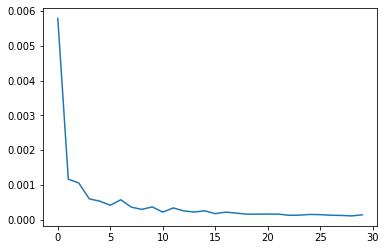

In [89]:
#plot loss to see when is good to stop epochs
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [90]:
# len(adtrain)#620
# len(adtest)# 35
len(adultcrit)# 655

655

In [91]:
#formatting input so that using the last 30 of train to start prediction on first day of test set which is the last 30 days
# 30 doesn't work take last 7 days of train to make prediction on first day of test set
last_train_batch = scaled_train[-7:]

In [92]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [93]:
model.predict(last_train_batch) # check first prediction of test vs actual

array([[0.498485]], dtype=float32)

In [94]:
scaled_test[0]

array([0.51664753])

In [95]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(adtest)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [96]:
true_predictions = scaler.inverse_transform(test_predictions)

In [97]:
adtest['Predictions'] = true_predictions

C:\Users\Jneny\AppData\Local\Temp\ipykernel_3700\426780066.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adtest['Predictions'] = true_predictions


<AxesSubplot:xlabel='date'>

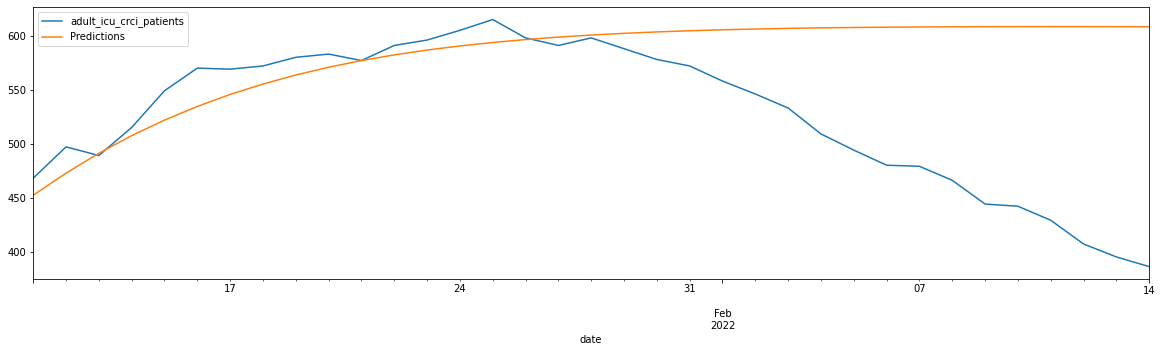

In [107]:
adtest.plot(figsize=(20,5))

In [104]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
import math
from math import sqrt
rmse= math.sqrt(mean_squared_error(adtest['adult_icu_crci_patients'], adtest['Predictions']))
print(rmse)

95.1131988172453


In [100]:
# calculate mean absolute percentage error MAPE
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
mape(adtest['adult_icu_crci_patients'], adtest['Predictions'])

14.12117661608703